# TASK - 2
**Programming and Maths for AI - INM702 Coursework**
\
Implementing CNN architecture for the dataset using PyTorch. Created a baseline where the following are the parameters:
1. Image size : 128x128
2. Learnign rate : 0.001
3. Optimizer: Adam
4. Batches : 32
5. Number of conv2d blocks : 3

Defining all the required libraries and setting the random seed for code reproducibility

In [68]:
import random
import numpy as np
import torch

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [69]:
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

Below code splits the data into training, testing and validation

In [ ]:
import os
import shutil
import random

SOURCE_DIR = "/content/drive/MyDrive/heartbeat-dataset"
OUTPUT_DIR = "/content/drive/MyDrive/heartbeat-data_new"

SPLIT_RATIO = {
    "train": 0.8,
    "val": 0.1,
    "test": 0.1
}

CLASSES = ["abnormal", "normal"]
for split in SPLIT_RATIO:
    for cls in CLASSES:
        os.makedirs(os.path.join(OUTPUT_DIR, split, cls), exist_ok=True)

for cls in CLASSES:
    class_dir = os.path.join(SOURCE_DIR, cls)
    images = os.listdir(class_dir)
    images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    random.shuffle(images)

    n_total = len(images)
    n_train = int(SPLIT_RATIO["train"] * n_total)
    n_val   = int(SPLIT_RATIO["val"] * n_total)

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train + n_val]
    test_imgs  = images[n_train + n_val:]

    split_map = {
        "train": train_imgs,
        "val": val_imgs,
        "test": test_imgs
    }

    for split, split_imgs in split_map.items():
        for img in split_imgs:
            src = os.path.join(class_dir, img)
            dst = os.path.join(OUTPUT_DIR, split, cls, img)
            shutil.copy(src, dst)

    print(f"{cls}: {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")


abnormal: 2128 train, 266 val, 266 test
normal: 2060 train, 257 val, 258 test


Creating data generators using pytorch

In [42]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import transforms

img_dims = 128
batch_size = 32

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_dims, img_dims)),
    transforms.ToTensor(),
])


In [43]:
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/heartbeat-data_new/train', transform=transform)
val_dataset   = datasets.ImageFolder('/content/drive/MyDrive/heartbeat-data_new/val', transform=transform)
test_dataset  = datasets.ImageFolder('/content/drive/MyDrive/heartbeat-data_new/test', transform=transform)


In [44]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
for X_batch, y_batch in train_loader:
    print(X_batch.shape)
    print(y_batch.shape)
    break


torch.Size([32, 1, 128, 128])
torch.Size([32])


PLotting the spectrograms

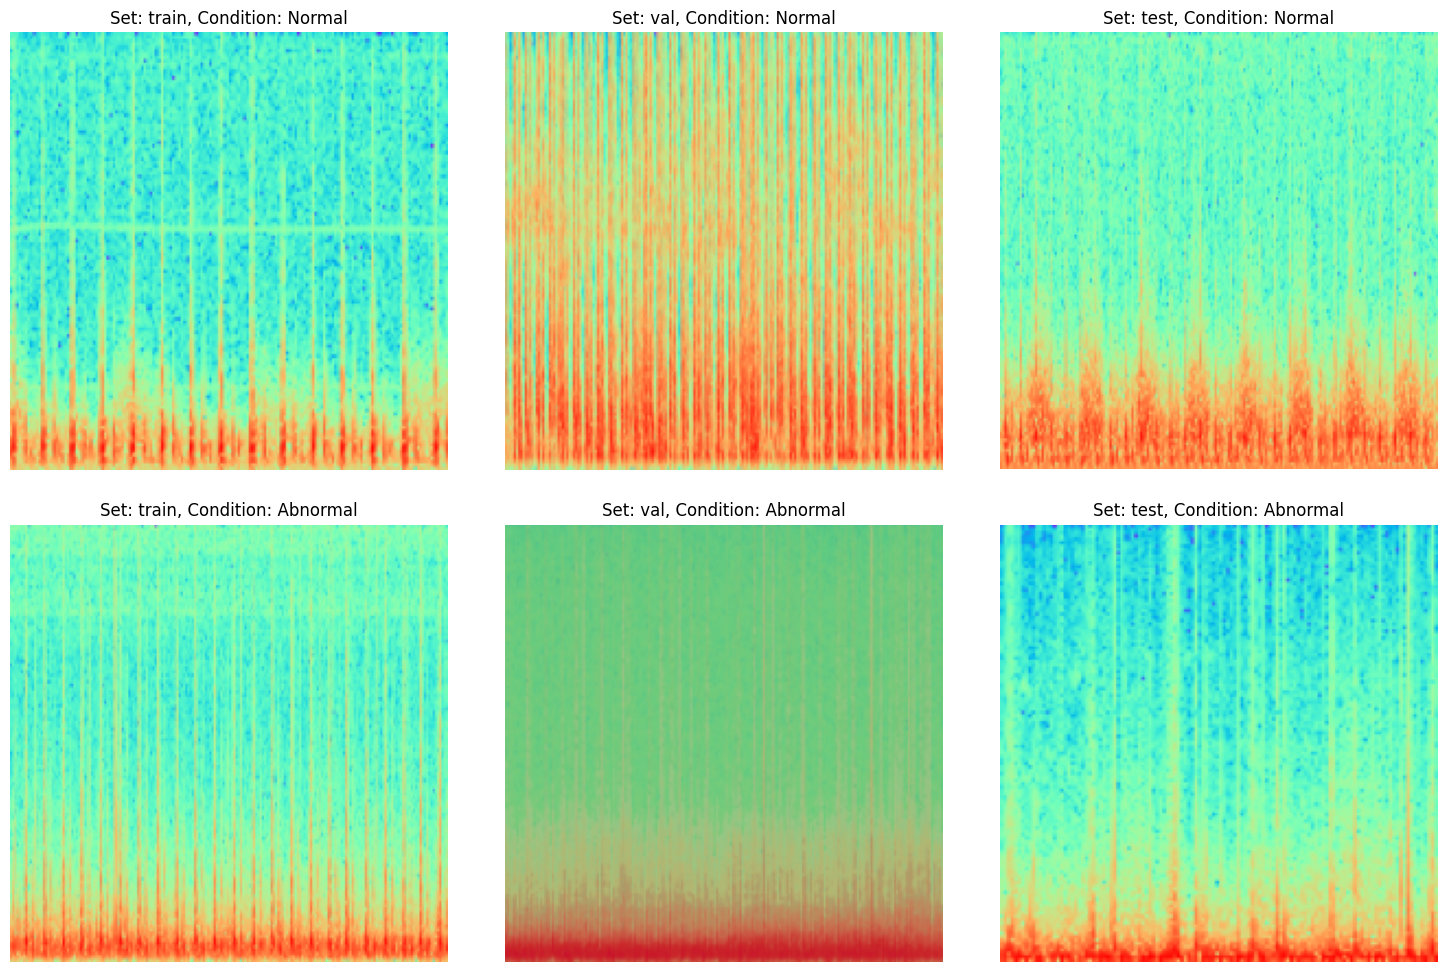

In [71]:
import matplotlib.pyplot as plt
import os

path = '/content/drive/MyDrive/heartbeat-data_new/'

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = os.path.join(path, _set)

    normal_folder = os.path.join(set_path, 'normal')
    normal_image = os.listdir(normal_folder)[0]
    ax[i].imshow(plt.imread(os.path.join(normal_folder, normal_image)), cmap='gray')
    ax[i].set_title(f'Set: {_set}, Condition: Normal')
    ax[i].axis('off')
    abnormal_folder = os.path.join(set_path, 'abnormal')
    abnormal_image = os.listdir(abnormal_folder)[0]
    ax[i+3].imshow(plt.imread(os.path.join(abnormal_folder, abnormal_image)), cmap='gray')
    ax[i+3].set_title(f'Set: {_set}, Condition: Abnormal')
    ax[i+3].axis('off')

plt.show()


The image size = 128x128
Batch size = 32
The dataset is split into three classes:
1. Train -> 4188 images
2. Test ->  523 images
3. Validation -> 524 images

Building the layers for the CNN Architecture

Experiment Number 1 : 
\
Drop out : 20% in the first block, drop out = 30% in the second block, drop out = 40% and 30%
Optimizer: Adam Optimizer
Activation function: ReLU(), Also implemented batch normalization which helps optimizer works better.
\
Number of epochs = 30
\
Learning rate = 0.001


In [72]:
img_dims = 128
epochs = 100
batch_size = 32

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HeartbeatCNN1(nn.Module):
    def __init__(self, img_dims=128):
        super(HeartbeatCNN1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2)
        )

        self.fc1 = nn.Linear(16 * (img_dims//2) * (img_dims//2), 64)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x


In [89]:
model = HeartbeatCNN1()
print(model)

HeartbeatCNN1(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=65536, out_features=64, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [90]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = HeartbeatCNN1().to(device)


In [91]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.001)


In [92]:
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import torch.nn.functional as F

num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
precisions, recalls, f1s = [], [], []

best_val_f1 = 0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    all_preds, all_labels = [], []

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        preds = (outputs >= 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    train_loss /= total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1).float()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            preds = (outputs >= 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())

    val_loss /= total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    precision = precision_score(val_labels, val_preds)
    recall = recall_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    if f1 > best_val_f1:
        best_val_f1 = f1
        torch.save(model.state_dict(), 'exp1_model.pth')

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
          f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'precisions': precisions,
    'recalls': recalls,
    'f1s': f1s
}, 'exp1_metrics.pth')

print("Training complete. All metrics saved to 'exp1_metrics.pth'.")


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30 | Train Acc: 0.5069 | Val Acc: 0.5086 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Epoch 2/30 | Train Acc: 0.5143 | Val Acc: 0.5736 | Precision: 0.5904 | Recall: 0.4319 | F1: 0.4989


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/30 | Train Acc: 0.5246 | Val Acc: 0.5086 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/30 | Train Acc: 0.5306 | Val Acc: 0.5086 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Epoch 5/30 | Train Acc: 0.5337 | Val Acc: 0.4990 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/30 | Train Acc: 0.5406 | Val Acc: 0.5086 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Epoch 7/30 | Train Acc: 0.5284 | Val Acc: 0.4895 | Precision: 0.2222 | Recall: 0.0156 | F1: 0.0291
Epoch 8/30 | Train Acc: 0.5380 | Val Acc: 0.6424 | Precision: 0.5833 | Recall: 0.9533 | F1: 0.7238
Epoch 9/30 | Train Acc: 0.5492 | Val Acc: 0.4952 | Precision: 0.3793 | Recall: 0.0428 | F1: 0.0769
Epoch 10/30 | Train Acc: 0.5497 | Val Acc: 0.5143 | Precision: 0.5246 | Recall: 0.1245 | F1: 0.2013
Epoch 11/30 | Train Acc: 0.5456 | Val Acc: 0.6577 | Precision: 0.5980 | Recall: 0.9261 | F1: 0.7267
Epoch 12/30 | Train Acc: 0.5530 | Val Acc: 0.5583 | Precision: 0.6275 | Recall: 0.2490 | F1: 0.3565
Epoch 13/30 | Train Acc: 0.5735 | Val Acc: 0.6577 | Precision: 0.6032 | Recall: 0.8872 | F1: 0.7181
Epoch 14/30 | Train Acc: 0.5740 | Val Acc: 0.6195 | Precision: 0.6768 | Recall: 0.4319 | F1: 0.5273
Epoch 15/30 | Train Acc: 0.5750 | Val Acc: 0.5832 | Precision: 0.6466 | Recall: 0.3346 | F1: 0.4410
Epoc

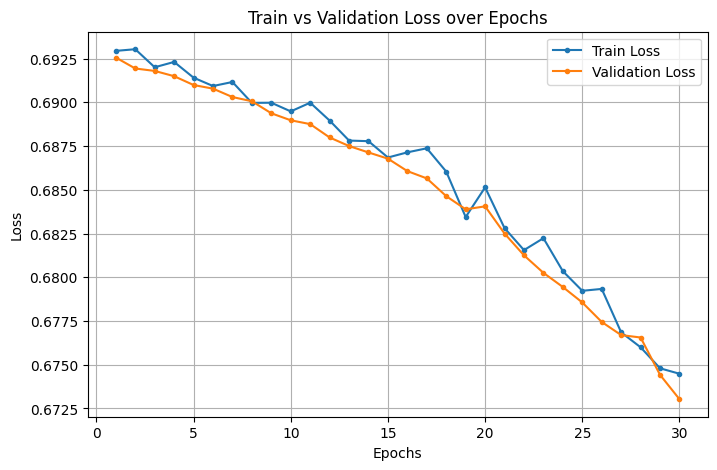

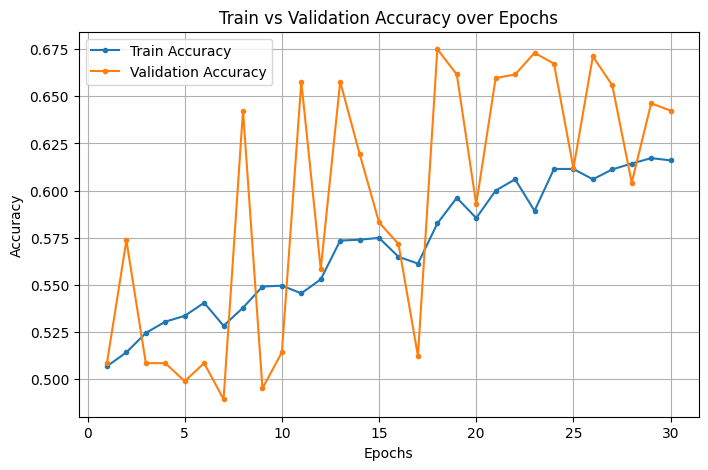

Text(0.5, 1.0, 'Precision, Recall, and F1 Score over Epochs')

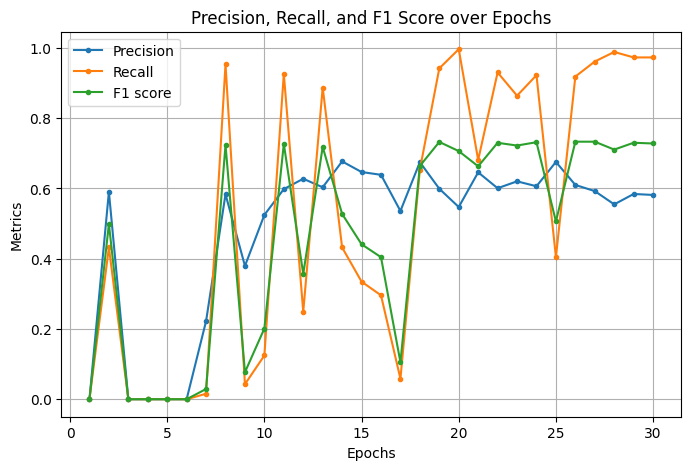

In [95]:
import torch
import matplotlib.pyplot as plt

metrics = torch.load('exp1_metrics.pth')
train_losses = metrics['train_losses']
val_losses = metrics['val_losses']
train_accuracies = metrics['train_accuracies']
val_accuracies = metrics['val_accuracies']
precisions = metrics['precisions']
recalls = metrics['recalls']
f1s = metrics['f1s']

epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label='Train Loss', marker='.')
plt.plot(epochs, val_losses, label='Validation Loss', marker='.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='.')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, precisions, label='Precision', marker='.')
plt.plot(epochs, recalls, label='Recall', marker='.')
plt.plot(epochs, f1s, label="F1 score", marker='.')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.title('Precision, Recall, and F1 Score over Epochs')

Experiment Number 2 : where learning rate = 1e-3
Drop out : 20% in the first block, drop out = 30% in the second block, drop out = 40% and 30%
\
Optimizer: Adam Optimizer
Activation function: ReLU(), Also implemented batch normalization which helps optimizer works better.
\
Learnign rate = 1e-3


In [104]:
img_dims = 128
epochs = 30
batch_size = 32

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HeartbeatCNN2(nn.Module):
    def __init__(self, img_dims=128):
        super(HeartbeatCNN2, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.3)
        )

        self.fc1 = nn.Linear(32 * (img_dims//4) * (img_dims//4), 64)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x


In [99]:
model = HeartbeatCNN2()
print(model)

HeartbeatCNN2(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=32768, out_features=64, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_fea

In [100]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = HeartbeatCNN2().to(device)

In [102]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [105]:
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import torch.nn.functional as F

num_epochs = 30

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
precisions, recalls, f1s = [], [], []

best_val_f1 = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    all_preds, all_labels = [], []

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        preds = (outputs >= 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    train_loss /= total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1).float()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            preds = (outputs >= 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())

    val_loss /= total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    precision = precision_score(val_labels, val_preds)
    recall = recall_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    if f1 > best_val_f1:
        best_val_f1 = f1
        torch.save(model.state_dict(), 'exp2_model.pth')

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
          f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'precisions': precisions,
    'recalls': recalls,
    'f1s': f1s
}, 'exp2_metrics.pth')

print("Training complete. All metrics saved to 'exp2_metrics.pth'.")


Epoch 1/30 | Train Acc: 0.7679 | Val Acc: 0.4685 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Epoch 2/30 | Train Acc: 0.7954 | Val Acc: 0.7591 | Precision: 0.7510 | Recall: 0.7626 | F1: 0.7568
Epoch 3/30 | Train Acc: 0.8255 | Val Acc: 0.4895 | Precision: 0.3438 | Recall: 0.0428 | F1: 0.0761
Epoch 4/30 | Train Acc: 0.8486 | Val Acc: 0.8853 | Precision: 0.8505 | Recall: 0.9300 | F1: 0.8885
Epoch 5/30 | Train Acc: 0.8617 | Val Acc: 0.8776 | Precision: 0.8434 | Recall: 0.9222 | F1: 0.8810
Epoch 6/30 | Train Acc: 0.8727 | Val Acc: 0.4952 | Precision: 0.1111 | Recall: 0.0039 | F1: 0.0075
Epoch 7/30 | Train Acc: 0.8835 | Val Acc: 0.8088 | Precision: 0.8127 | Recall: 0.7938 | F1: 0.8031
Epoch 8/30 | Train Acc: 0.8809 | Val Acc: 0.8757 | Precision: 0.8967 | Recall: 0.8444 | F1: 0.8697
Epoch 9/30 | Train Acc: 0.8859 | Val Acc: 0.8967 | Precision: 0.8691 | Recall: 0.9300 | F1: 0.8985
Epoch 10/30 | Train Acc: 0.8871 | Val Acc: 0.8757 | Precision: 0.8380 | Recall: 0.9261 | F1: 0.8799
Epoch 11/

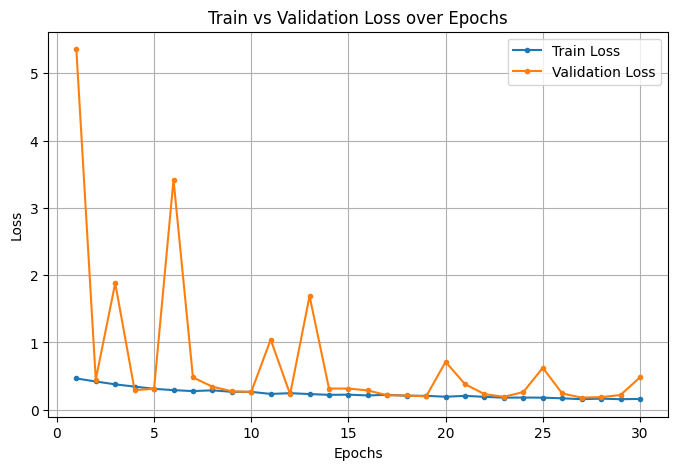

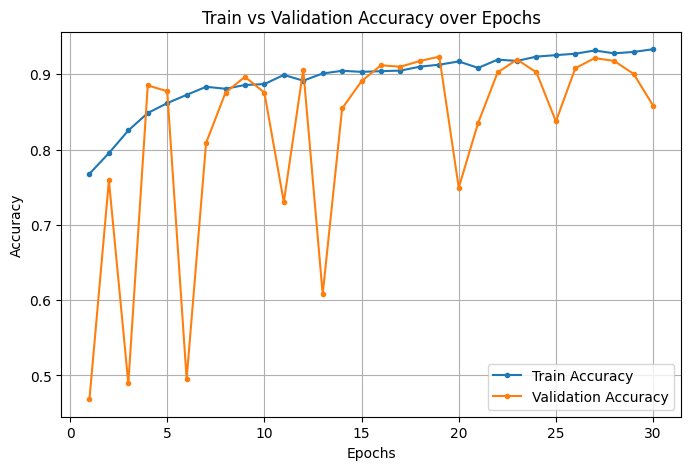

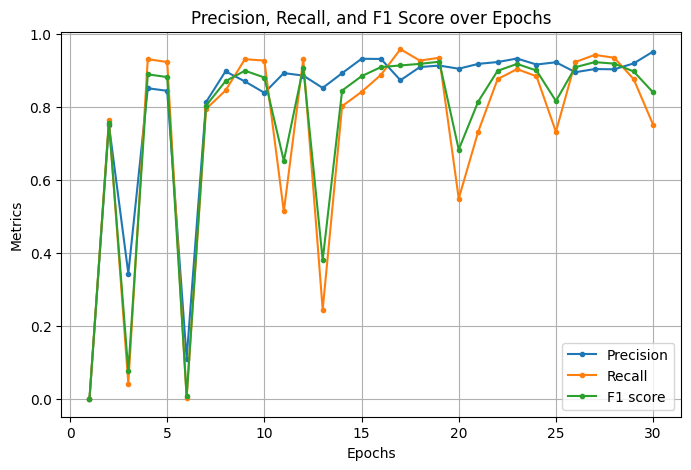

In [106]:
import torch
import matplotlib.pyplot as plt

# Load metrics
metrics = torch.load('exp2_metrics.pth')

train_losses = metrics['train_losses']
val_losses = metrics['val_losses']
train_accuracies = metrics['train_accuracies']
val_accuracies = metrics['val_accuracies']
precisions = metrics['precisions']
recalls = metrics['recalls']
f1s = metrics['f1s']

epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label='Train Loss', marker='.')
plt.plot(epochs, val_losses, label='Validation Loss', marker='.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='.')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, precisions, label='Precision', marker='.')
plt.plot(epochs, recalls, label='Recall', marker='.')
plt.plot(epochs, f1s, label="F1 score", marker='.')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Precision, Recall, and F1 Score over Epochs')
plt.legend()
plt.grid(True)

Experiment Number 3: where learning rate = 1e-3
Drop out : 20% in the first block, drop out = 30% in the second block, drop out = 40% and 30%
Optimizer: Adam Optimizer
Activation function: ReLU(), Also implemented batch normalization which helps optimizer works better.
\
This time ran the experiment for 100 epochs
\
Learning rate = 1e-5

In [87]:
img_dims = 128
epochs = 100
batch_size = 32

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HeartbeatCNN(nn.Module):
    def __init__(self, img_dims=128):
        super(HeartbeatCNN, self).__init__()

        # --- First conv block ---
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2)
        )

        # --- Second conv block ---
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.3)
        )

        # --- Fully connected layers ---
        self.fc1 = nn.Linear(32 * (img_dims//4) * (img_dims//4), 64)  # after 2 poolings
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x


In [74]:
model = HeartbeatCNN()
print(model)

HeartbeatCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=32768, out_features=64, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_feat

In [75]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = HeartbeatCNN().to(device)


In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-5)


In [77]:
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import torch.nn.functional as F

num_epochs = 100

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
precisions, recalls, f1s = [], [], []

best_val_f1 = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    all_preds, all_labels = [], []

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        preds = (outputs >= 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    train_loss /= total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1).float()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            preds = (outputs >= 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())

    val_loss /= total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    precision = precision_score(val_labels, val_preds)
    recall = recall_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    if f1 > best_val_f1:
        best_val_f1 = f1
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
          f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'precisions': precisions,
    'recalls': recalls,
    'f1s': f1s
}, 'new_metrics.pth')

print("Training complete. All metrics saved to 'training_metrics.pth'.")


Epoch 1/100 | Train Acc: 0.5501 | Val Acc: 0.4398 | Precision: 0.1087 | Recall: 0.0195 | F1: 0.0330
Epoch 2/100 | Train Acc: 0.5960 | Val Acc: 0.6176 | Precision: 0.6183 | Recall: 0.5798 | F1: 0.5984
Epoch 3/100 | Train Acc: 0.6511 | Val Acc: 0.6711 | Precision: 0.6110 | Recall: 0.9105 | F1: 0.7312
Epoch 4/100 | Train Acc: 0.7137 | Val Acc: 0.7036 | Precision: 0.6536 | Recall: 0.8444 | F1: 0.7368
Epoch 5/100 | Train Acc: 0.7445 | Val Acc: 0.7036 | Precision: 0.6401 | Recall: 0.9066 | F1: 0.7504
Epoch 6/100 | Train Acc: 0.7710 | Val Acc: 0.7132 | Precision: 0.6458 | Recall: 0.9222 | F1: 0.7596
Epoch 7/100 | Train Acc: 0.7930 | Val Acc: 0.7170 | Precision: 0.6485 | Recall: 0.9261 | F1: 0.7628
Epoch 8/100 | Train Acc: 0.7997 | Val Acc: 0.7132 | Precision: 0.6450 | Recall: 0.9261 | F1: 0.7604
Epoch 9/100 | Train Acc: 0.8066 | Val Acc: 0.7400 | Precision: 0.6649 | Recall: 0.9494 | F1: 0.7821
Epoch 10/100 | Train Acc: 0.8204 | Val Acc: 0.7725 | Precision: 0.6971 | Recall: 0.9494 | F1: 0.8040

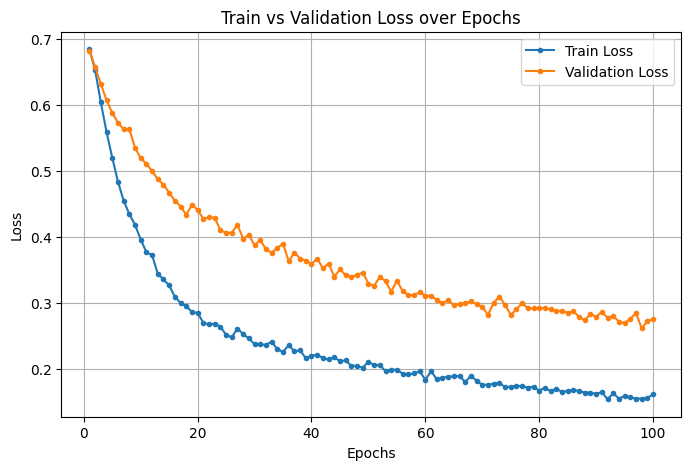

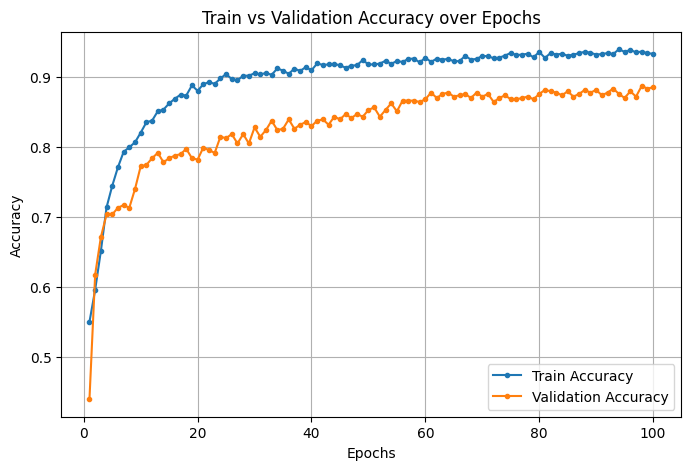

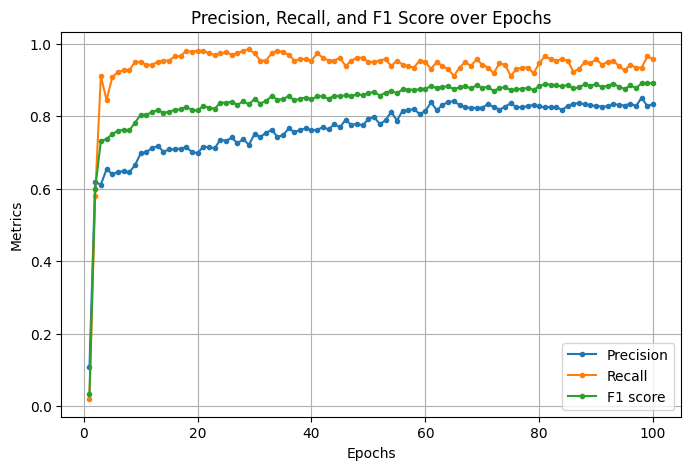

In [96]:
import torch
import matplotlib.pyplot as plt

# Load metrics
metrics = torch.load('new_metrics.pth')

train_losses = metrics['train_losses']
val_losses = metrics['val_losses']
train_accuracies = metrics['train_accuracies']
val_accuracies = metrics['val_accuracies']
precisions = metrics['precisions']
recalls = metrics['recalls']
f1s = metrics['f1s']

epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label='Train Loss', marker='.')
plt.plot(epochs, val_losses, label='Validation Loss', marker='.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='.')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, precisions, label='Precision', marker='.')
plt.plot(epochs, recalls, label='Recall', marker='.')
plt.plot(epochs, f1s, label="F1 score", marker='.')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Precision, Recall, and F1 Score over Epochs')
plt.legend()
plt.grid(True)

Computing test accuracy with the best set of parameters

In [107]:
import torch
from sklearn.metrics import accuracy_score

model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1).float()

        outputs = model(X_batch)
        preds = (outputs >= 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8969


Plotting training, testign and validation for the best architecture for CNN

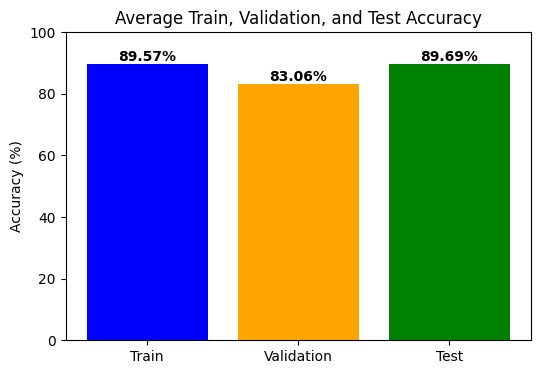

In [114]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

metrics = torch.load('new_metrics.pth')

train_acc_avg = (sum(metrics['train_accuracies']) / len(metrics['train_accuracies'])) * 100
val_acc_avg = (sum(metrics['val_accuracies']) / len(metrics['val_accuracies'])) * 100

model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1).float()

        outputs = model(X_batch)
        preds = (outputs >= 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds) * 100


accuracies = [train_acc_avg, val_acc_avg, test_acc]
labels = ['Train', 'Validation', 'Test']

plt.figure(figsize=(6,4))
plt.bar(labels, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Average Train, Validation, and Test Accuracy')
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')
plt.show()
